# QNLP Experiment
In this mini-experiment, we will use the SPSA optimiser to learn the the parameters of a simple DisCoCat model. 

First, we generate some sentences using the vocabulary "Alice", "loves", "Bob", "who" and "is rich". By assigning the correct grammatical types to each word, DisCoPy will only generate grammatically correct sentences.

In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich]

In [2]:
from time import time
from discopy.grammar import brute_force

gen, n_sentences = brute_force(*vocab), 10
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.

2.29 seconds to generate 10 sentences.


Diagram for 'Alice who loves Bob is rich.':


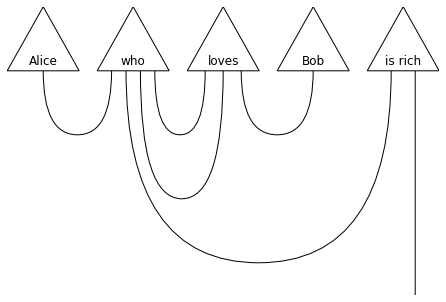

In [3]:
from discopy.grammar import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice who loves Bob is rich.'], draw_type_labels=False)

Now we construct a `CircuitFunctor` which transforms the diagrams into quantum circuits. This involves providing a mapping from each grammatical type (e.g. `Ty('n')`, or `Ty('s')`) to the number of qubits, and a mapping from each DisCoPy box to a quantum circuit. For larger models, one can provide a function to `ob` and `ar` for the `Functor` constructor.

Circuit for the GHZ state, used as ansatz for "who":


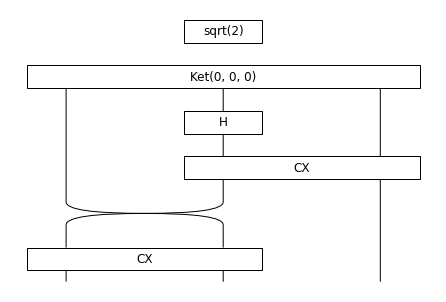

In [4]:
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP

# Ansatz for words with type `n`, e.g. 'Alice', 'Bob'
def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

# Ansatz for words with type `n.r @ s @ n.l`, e.g. 'loves'
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state, used as ansatz for \"who\":")
GHZ.draw(aspect='auto', draw_type_labels=False)

Once we have defined the circuits for each box, we can define `F`, a function that takes a list of two parameters, and returns a `CircuitFunctor` which transforms a diagram into a circuit.

Circuit for 'Alice who loves Bob is rich.':


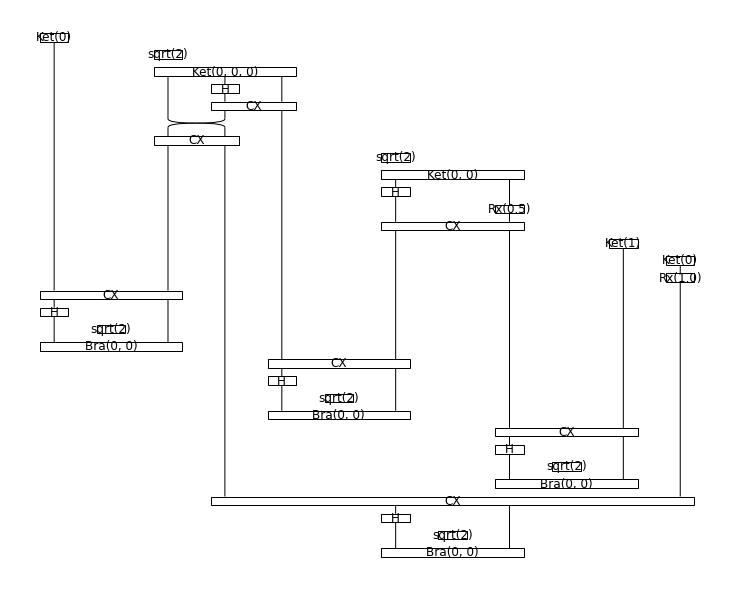

In [5]:
import numpy as np
from discopy import CircuitFunctor, qubit

F = lambda params: CircuitFunctor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(0),
        loves: transitive_ansatz(params[0]),
        Bob: Ket(1),
        who: GHZ,
        is_rich: intransitive_ansatz(params[1])})

params0 = np.array([0.5, 1.0])
print("Circuit for 'Alice who loves Bob is rich.':")
circuit = F(params0)(parsing['Alice who loves Bob is rich.'])
circuit.draw(figsize=(10, 8), aspect='auto', draw_type_labels=False)

This circuit diagram can be exported to `pytket`, which can be used to compile circuits for many backends such as IBM's `qiskit`.

In [6]:
from pytket.qiskit import tk_to_qiskit

tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit, qubits=8, gates=24>:
H q[1];
H q[4];
Rx(1*PI) q[5];
X q[6];
Rx(2*PI) q[7];
CX q[1], q[3];
CX q[4], q[5];
CX q[1], q[2];
CX q[3], q[4];
CX q[5], q[6];
Measure q[4] --> c[3];
Measure q[6] --> c[5];
CX q[0], q[1];
CX q[2], q[7];
H q[3];
H q[5];
Measure q[1] --> c[1];
Measure q[3] --> c[2];
Measure q[5] --> c[4];
Measure q[7] --> c[7];
H q[0];
H q[2];
Measure q[0] --> c[0];
Measure q[2] --> c[6];

post selection:
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

scalar:
64.00000000000009

qiskit circuit:


┌───┐                   ┌─┐   
q_0: ───────────────────────■──┤ H ├───────────────────┤M├───
        ┌───┐             ┌─┴─┐└───┘     ┌─┐           └╥┘   
q_1: ───┤ H ├─────■────■──┤ X ├──────────┤M├────────────╫────
        └───┘     │  ┌─┴─┐└───┘          └╥┘┌───┐       ║ ┌─┐
q_2: ─────────────┼──┤ X ├────────────■───╫─┤ H ├───────╫─┤M├
                ┌─┴─┐└───┘┌───┐       │   ║ └┬─┬┘       ║ └╥┘
q_3: ───────────┤ X ├──■──┤ H ├───────┼───╫──┤M├────────╫──╫─
        ┌───┐   └───┘┌─┴─┐└┬─┬┘       │   ║  └╥┘        ║  ║ 
q_4: ───┤ H ├─────■──┤ X ├─┤M├────────┼───╫───╫─────────╫──╫─
      ┌─┴───┴──┐┌─┴─┐└───┘ └╥┘ ┌───┐  │   ║   ║  ┌─┐    ║  ║ 
q_5: ─┤ RX(pi) ├┤ X ├──■────╫──┤ H ├──┼───╫───╫──┤M├────╫──╫─
      └─┬───┬──┘└───┘┌─┴─┐  ║  └┬─┬┘  │   ║   ║  └╥┘    ║  ║ 
q_6: ───┤ X ├────────┤ X ├──╫───┤M├───┼───╫───╫───╫─────╫──╫─
     ┌──┴───┴──┐     └───┘  ║   └╥┘ ┌─┴─┐ ║   ║   ║ ┌─┐ ║  ║ 
q_7: ┤ RX(2pi) ├────────────╫────╫──┤ X ├─╫───╫───╫─┤M├─╫──╫─
     └─────────┘            ║    ║  └───┘ ║   ║   ║ └╥┘ ║  ║ 
c: 8/═══════════════════════╩════╩════════╩═══╩═══╩══╩══╩══╩═
                            3    5        1   2   4  7  0  6

The rest of this code follows a typical machine learning setup:
1) Define an evaluation function to predict labels based on input
2) Define a loss function to compare the predicted label with the actual label
3) Use an optimiser to minimise the loss

In [7]:
from pytket.backends.ibm import AerBackend

def evaluate(params, sentences, backend=AerBackend(), n_shots=2**10, seed=0):
    circuits = [F(params)(parsing[s]) for s in sentences]
    results = [Circuit.eval(
                circuit,
                backend=backend,
                n_shots=n_shots,
                seed=seed,
                compilation=backend.default_compilation_pass(2)) for circuit in circuits]
    tensors = [np.abs(result.array)[0] for result in results]
    return tensors

In [8]:
start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .01

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

0.647 seconds to compute the corpus.

True sentences:
Alice is rich. (1.035)
Alice loves Bob. (1.125)
Bob loves Alice. (1.125)
Alice who is rich is rich. (1.188)
Alice who loves Bob is rich. (1.000)

False sentences:
Bob is rich. (0.000)
Alice loves Alice. (0.000)
Bob loves Bob. (0.000)
Bob who is rich is rich. (0.000)
Alice who loves Alice is rich. (0.000)

Maybe sentences:



In [9]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=237)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(sentence_test)))

Training set:
Alice who is rich is rich.
Bob is rich.
Alice is rich.
Alice loves Bob.
Alice loves Alice.

Testing set:
Bob loves Bob.
Alice who loves Alice is rich.
Bob loves Alice.
Alice who loves Bob is rich.
Bob who is rich is rich.


In [10]:
def loss(params, sentences=sentence_train):
    return - np.mean(np.array([
        (corpus[sentence] - scalar) ** 2
        for sentence, scalar in zip(sentences, evaluate(params, sentences))]))

In [11]:
from random import random, seed; seed(337)

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(params, ['Alice who loves Bob is rich.'])[0] > .5 + delta
      else "No, she isn't.")

Random initialisation: [0.2018591  0.83909858]

Is Alice who loves Bob rich?
No, she isn't.


In [12]:
import noisyopt

i, start = 0, time()

def callback(params):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, params))

result = noisyopt.minimizeSPSA(
    loss, params, paired=False, callback=callback, niter=10, a=2)
result

Epoch 1 (1 seconds since start): [0.2018591  0.83909858]
Epoch 2 (1 seconds since start): [0.23054751 0.81041017]
Epoch 3 (2 seconds since start): [0.63904526 1.21890791]
Epoch 4 (2 seconds since start): [0.81880087 1.0391523 ]
Epoch 5 (3 seconds since start): [0.56664427 0.7869957 ]
Epoch 6 (3 seconds since start): [0.76280267 0.9831541 ]
Epoch 7 (4 seconds since start): [0.56321278 1.18274399]
Epoch 8 (4 seconds since start): [0.31946113 0.93899234]
Epoch 9 (5 seconds since start): [0.3595684  0.89888507]
Epoch 10 (5 seconds since start): [0.32048888 0.93796459]


     fun: -0.04558486938476568
 message: 'terminated after reaching max number of iterations'
    nfev: 20
     nit: 10
 success: True
       x: array([0.32048888, 0.93796459])

In [13]:
print("Testing loss: {}".format(loss(result.x, sentences=sentence_test)))

Testing loss: -0.08946533203125015


In [14]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(result.x, ['Alice who loves Bob is rich.'])[0] > .5 + delta
      else "No, she isn't.")

Is Alice who loves Bob rich?
Yes, she is.
